# Addictive Model

## Libraries

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## Import Dataset

In [75]:
file_path = '../data/food_data_cleaned1.xlsx'
food_data = pd.ExcelFile(file_path)
data = food_data.parse('Sheet1')
data.head()

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Categories,Countries,Barcode,Nutri-Score,Ecoscore
0,Sésame,1961.0,17.0,2.0,0.38,10.0,4.6,0,"Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",en:france,3175680011480,b,57
1,Lindt Excellence 90% 100g,2590.0,7.0,30.0,0.03,10.0,14.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:algeria, en:belgium, en:czech-republic, en:...",3046920029759,d,29
2,Excellence 85% Cacao Chocolat Noir Puissant,2418.0,15.0,27.0,0.02,12.5,0.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:austria, en:belgium, en:france, en:germany,...",3046920022606,e,29
3,Cashews,2510.0,6.5,9.0,0.02,20.5,5.2,100,"Plant-based foods and beverages,Plant-based fo...","en:austria, en:belgium, en:croatia, en:france,...",20267605,b,30
4,Tuc Original,2021.0,7.1,9.0,1.70,8.3,2.4,0,"Imbiss,Salzige Snacks,Vorspeisen,en:Biscuits a...","en:austria, en:belgium, en:denmark, en:estonia...",5410041001204,e,62


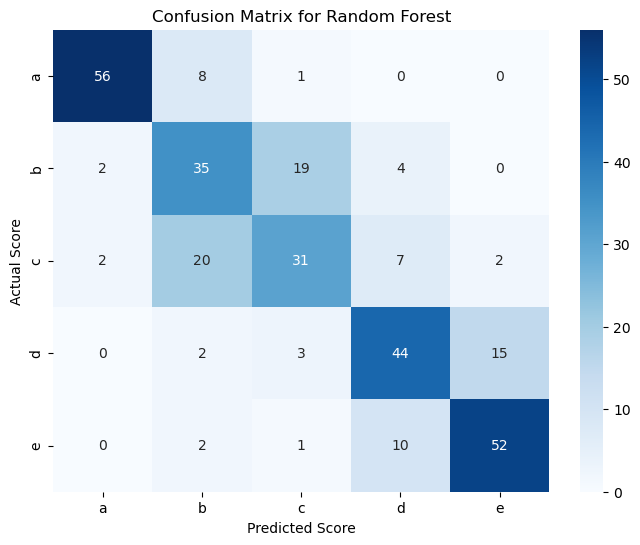

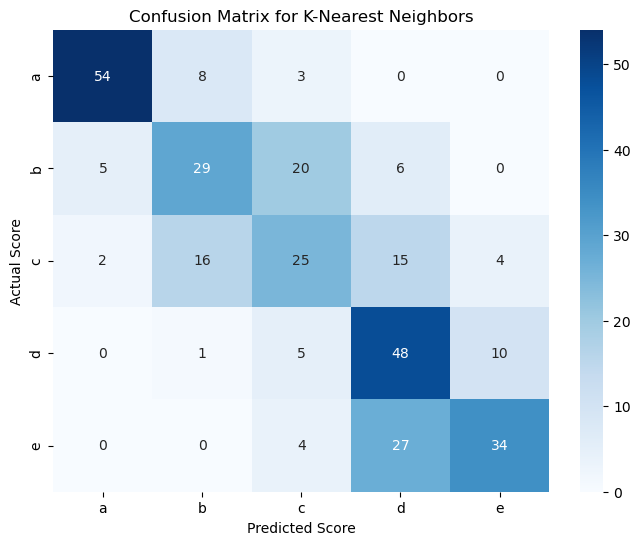

/home/yutao/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


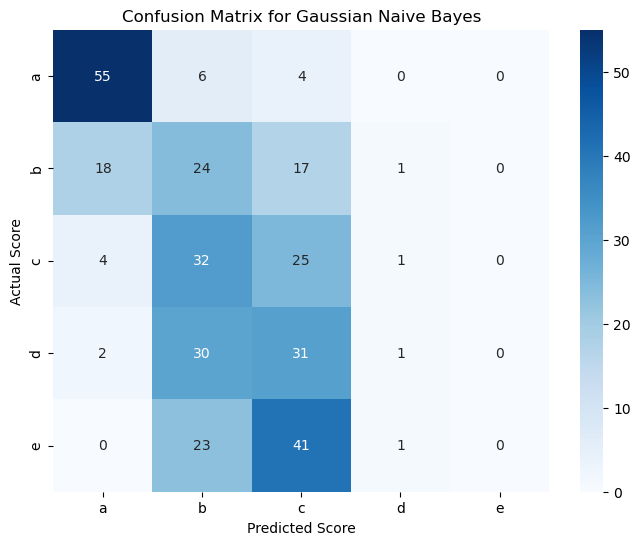

/home/yutao/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


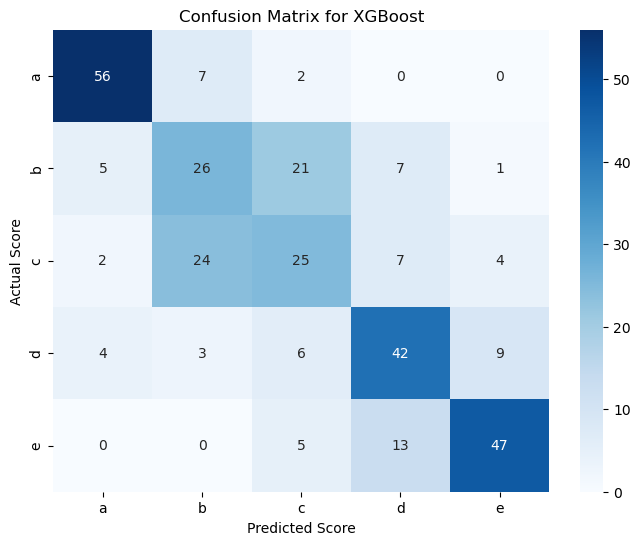

                  Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest  0.689873   0.693873  0.689873  0.690735
1   K-Nearest Neighbors  0.601266   0.617082  0.601266  0.600652
2  Gaussian Naive Bayes  0.332278   0.275033  0.332278  0.269666
3               XGBoost  0.620253   0.619108  0.620253  0.619255


In [76]:
def AnotherMethodNutriScoreWithVisualization(data, nutri_score_mapping, test_size=0.8, random_state=1):
    # Map and preprocess Nutri-Score
    data['Nutri-Score'] = data['Nutri-Score'].map(nutri_score_mapping)
    data = data.dropna(subset=['Nutri-Score'])
    data['Nutri-Score'] -= 1

    features = ['Energy (KJ/100g)', 'Proteins (g/100g)', 'Salt (g/100g)', 
                'Fiber (g/100g)', 'Saturated Fat (g/100g)', 'Sugars (g/100g)', 
                'Fruit/Veg (%)', 'Ecoscore']
    X = data[features]
    y = data['Nutri-Score']
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X = poly.fit_transform(X)
    
    # Resample with SMOTE
    smote = SMOTE(random_state=random_state)
    X, y = smote.fit_resample(X, y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Define models
    models = {
        "Random Forest": RandomForestClassifier(random_state=random_state, class_weight="balanced"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Gaussian Naive Bayes": GaussianNB(),
        "XGBoost": XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
    }
    
    performance = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        y_pred += 1
        y_test_vis = y_test + 1  
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test_vis, y_pred)
        precision = precision_score(y_test_vis, y_pred, average='weighted')
        recall = recall_score(y_test_vis, y_pred, average='weighted')
        f1 = f1_score(y_test_vis, y_pred, average='weighted')
        
        performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })
        
        # Plot confusion matrix
        labels = ['a', 'b', 'c', 'd', 'e']  # Adjust based on your data
        plot_confusion_matrix(y_test_vis, y_pred, labels, title=f"Confusion Matrix for {name}")
    
    # Output performance metrics
    performance_df = pd.DataFrame(performance)
    print(performance_df)

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[i + 1 for i in range(len(labels))])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Score')
    plt.ylabel('Actual Score')
    plt.title(title)
    plt.show()

if __name__ == "__main__":
    nutri_score_mapping = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}

    AnotherMethodNutriScoreWithVisualization(data, nutri_score_mapping)
